# LLM APIs

We're going to use examples of free existing APIs to understand how LLM work and how we can use them.

We'll cover the following APIs:
- Huggingface Inference API
- Gemini API

Topics we'll cover:
- Setting things up
- Text generation
- Multimodal generation
- Constrained generation

## Huggingface Inference API

Requirements:
- a huggingface account -> https://huggingface.co/join
- a token to authenticate with the API -> https://huggingface.co/settings/tokens/new

Steps to setup:

1. When creating a new token, make sure to set the type to "fine-grained", name it, and check the "Make calls to ..." under the "Inference" permission.
<div>
<img src="https://raw.githubusercontent.com/legraphista/llm-lab/9bf3f85aabace2a96a1f5bf49ed08b35d58fc4c3/.images/create_hf_inference_token.png" width="500"/>
</div>
2. Copy the token and save it in a secure place.

___

Rate limits: https://huggingface.co/docs/api-inference/rate-limits

In [ ]:
!pip install -q huggingface_hub --upgrade

In [58]:
def get_hf_token():
    print("Please provide your Hugging Face token.")
    hf_token = input("Please paste your Hugging Face token here: ")
    try:
        from huggingface_hub import HfApi
        api = HfApi()
        print('logged in as', api.whoami(token=hf_token)['name'])
    except Exception as e:
        print("Make sure your Hugging Face key is correct.")
        print(f"Error: {e}")
    return hf_token

hf_token = get_hf_token()

Please provide your Hugging Face token.
logged in as legraphista


In [59]:
from huggingface_hub import InferenceClient

client = InferenceClient(api_key=hf_token)

In [75]:
from IPython.display import display, HTML

def create_collapsible_group(group, models):
    models_html = "\n".join([f"<li>{model}</li>" for model in models])
    return f"""
    <details>
        <summary>{group}</summary>
        <ul>
            {models_html}
        </ul>
    </details>
    """

html_content = ""
for group, models in client.list_deployed_models().items():
    html_content += create_collapsible_group(group, models)

display(HTML(html_content))

### Testing the API with text-to-text generation

In [60]:
messages = [
	{ "role": "user", "content": "When is Alan Turing birthday?" }
]

output = client.chat.completions.create(
    model="Qwen/Qwen2.5-72B-Instruct", 
	messages=messages, 
	stream=True, 
)

for chunk in output:
    print(chunk.choices[0].delta.content, end='', flush=True)

Alan Turing's birthday is June 23, 1912.

In [61]:
messages = [
	{ 
        "role": "user", 
        "content": "I want to make a link shortener. Give me a list of creative, never before seen names that i can use." 
    }
]

[low_temp, high_temp] = [
    client.chat.completions.create(
        model="meta-llama/Llama-3.2-1B-Instruct", 
        messages=messages, 
        stream=False, 
        seed=42,
        temperature=0.6,
        max_tokens=512,
    ),
    client.chat.completions.create(
        model="meta-llama/Llama-3.2-1B-Instruct", 
        messages=messages, 
        stream=False, 
        seed=42,
        temperature=1,
        max_tokens=512,
    )   
]

[mk_low_temp, mk_high_temp] = [
    low_temp.choices[0].message.content,
    high_temp.choices[0].message.content,
]

!pip -q install markdown ipywidgets

from IPython.display import display
from markdown import markdown
from ipywidgets import HBox, Layout, HTML

display(HBox([
    HTML(value=markdown(mk_low_temp), layout=Layout(width='50%')),
    HTML(value=markdown(mk_high_temp), layout=Layout(width='50%'))
], layout=Layout(display='flex', flex_flow='row', justify_content='space-between', width='100%')))


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


### Testing the API with image-to-text

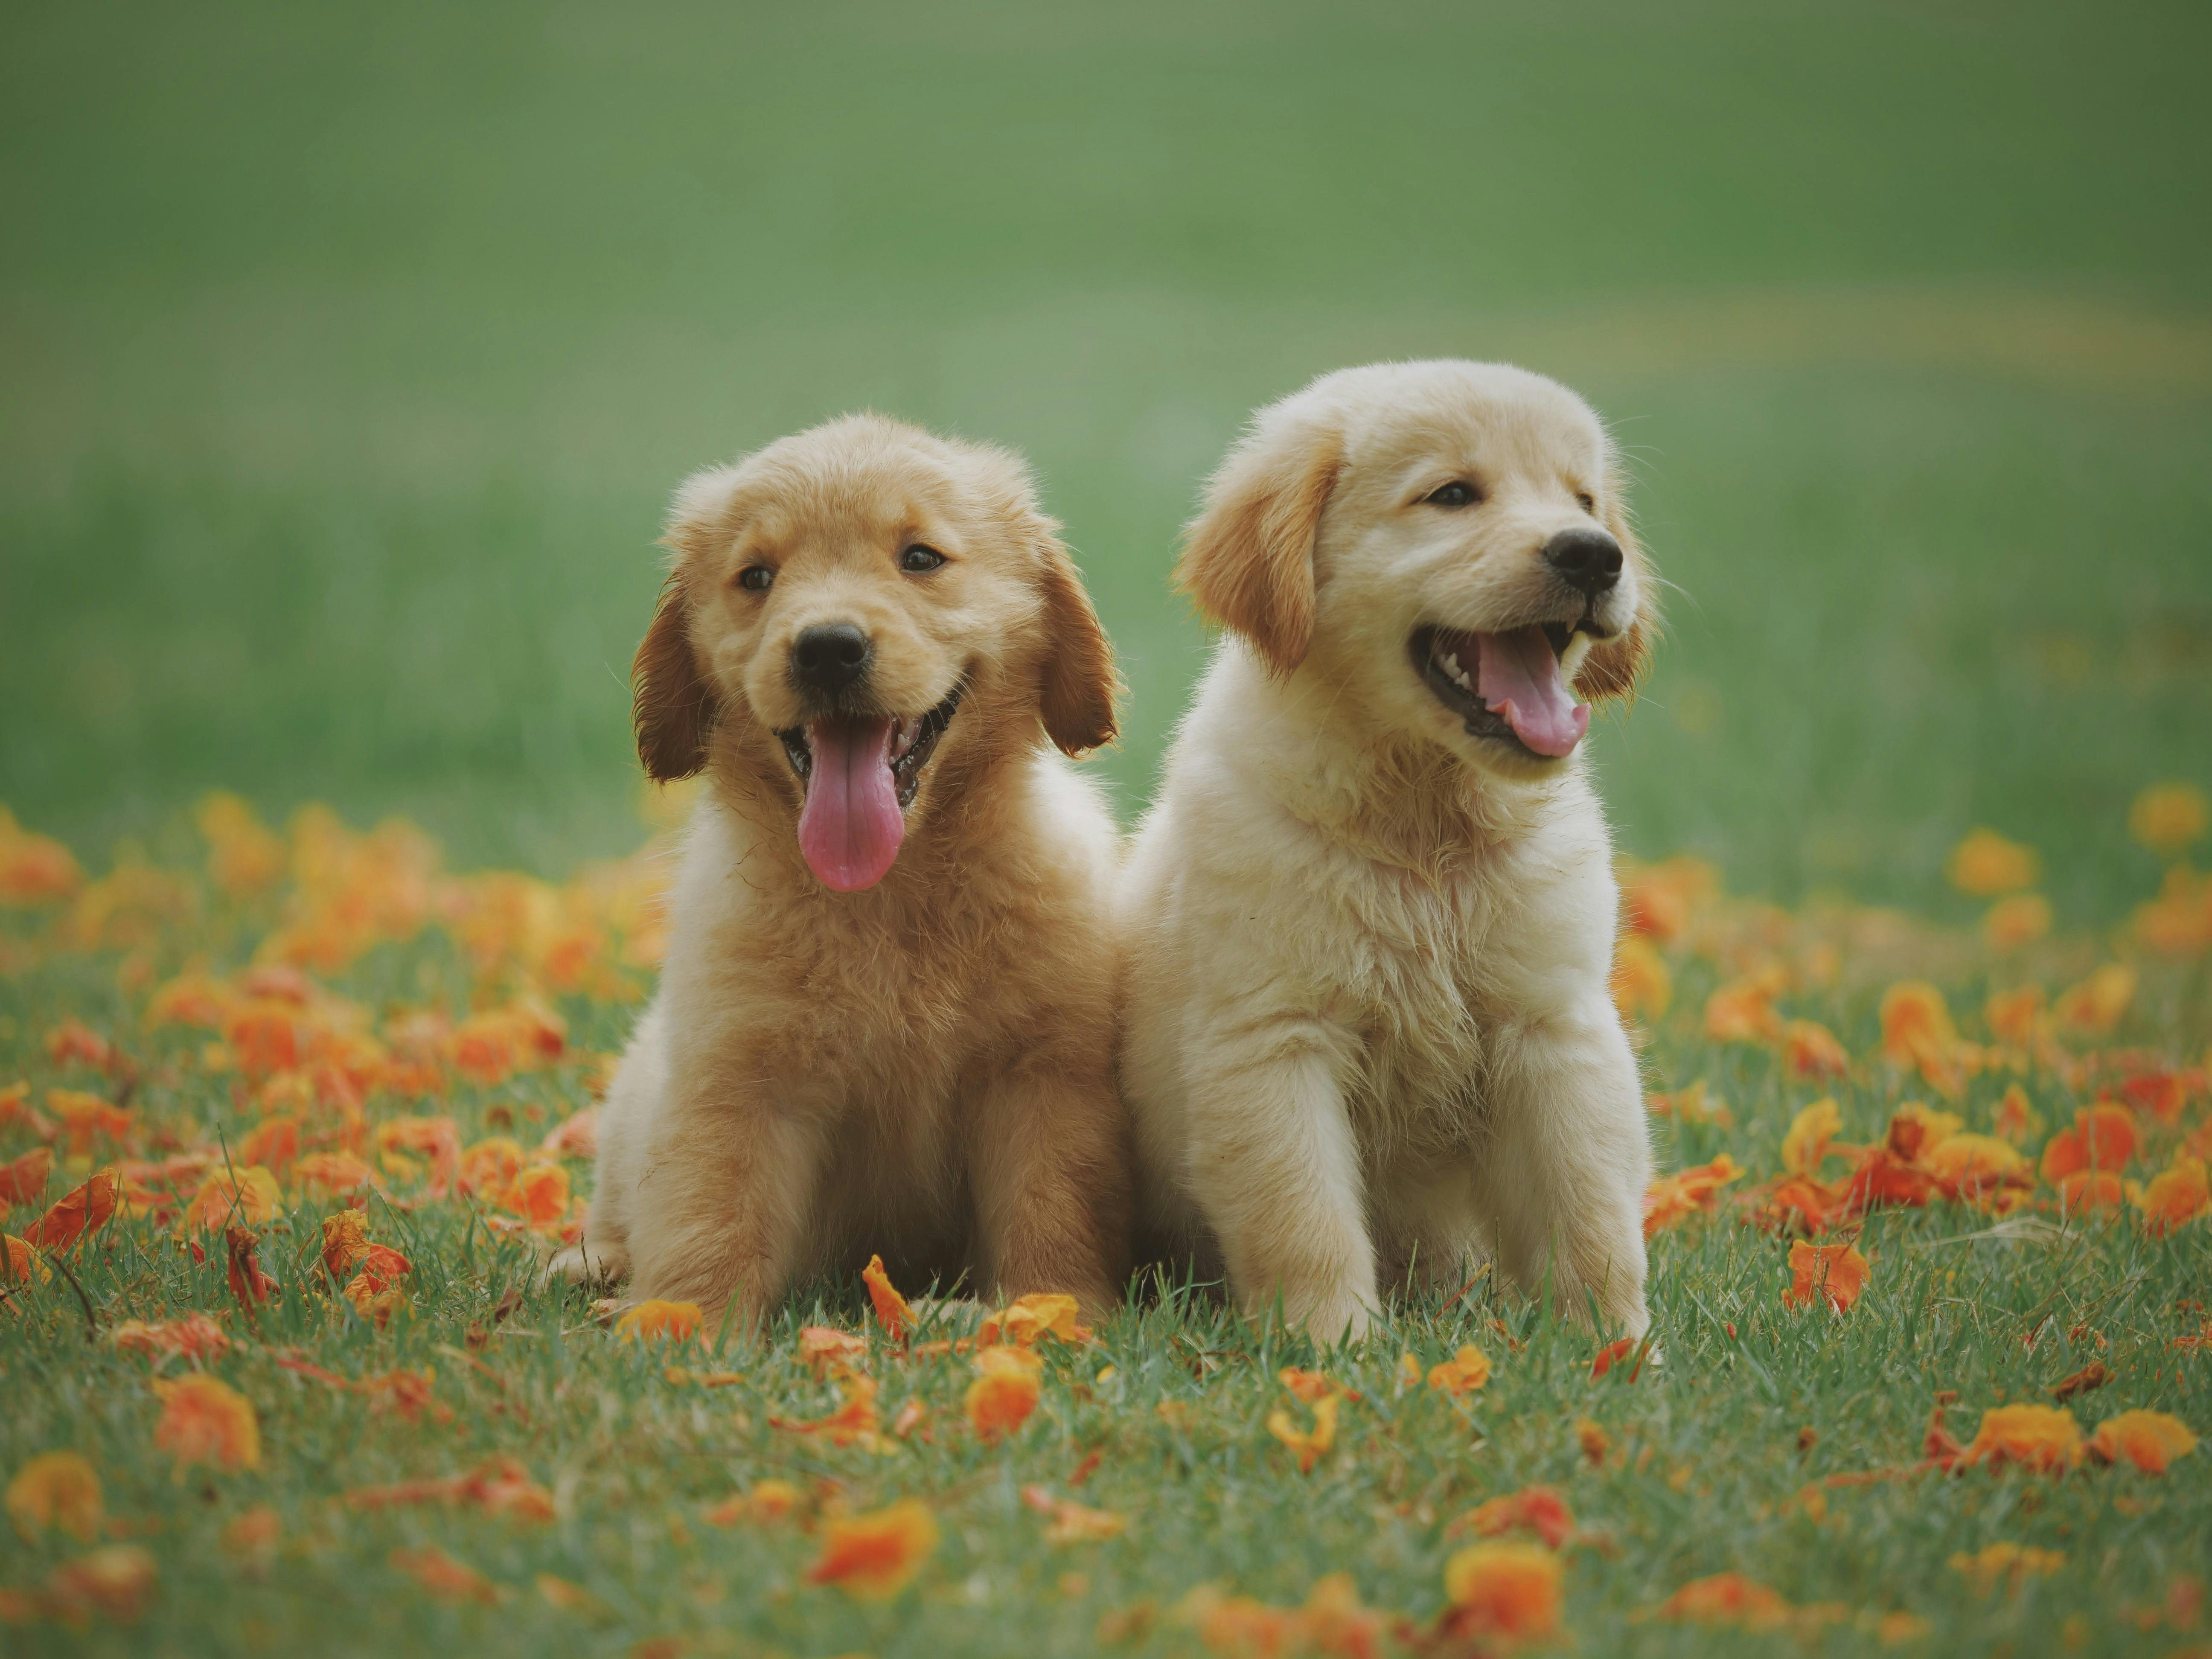

ImageToTextOutput(generated_text='there are two dogs sitting in the grass with flowers in the background', image_to_text_output_generated_text=None)

In [87]:

# Download and display sample image
import requests
from IPython.display import Image, display

image_url = 'https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg'
response = requests.get(image_url, headers={'User-Agent': 'Mozilla/5.0'})
display(Image(response.content, width=500))


output = client.image_to_text(
    image=image_url,
    model="Salesforce/blip-image-captioning-large",
)

output


### Testing the API with image-text-to-image

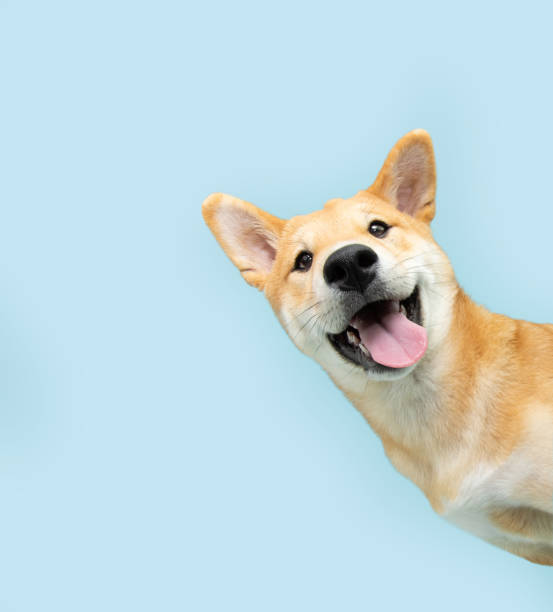

The image features a dog with a light-brown coat and white markings, its mouth open in a cheerful expression. The dog's head is tilted slightly to the left, and its ears are perked up. The background of the image is a solid light blue color.

**Key Features:**

* **Dog:** Light-brown coat with white markings
* **Mouth:** Open, showing teeth and tongue
* **Ears:** Perked up
* **Background:** Solid light blue color

**Overall Impression:**

The image appears to be a playful and happy depiction of a dog, possibly used for advertising or promotional purposes.

In [94]:
image_url = 'https://media.istockphoto.com/id/1503385646/photo/portrait-funny-and-happy-shiba-inu-puppy-dog-peeking-out-from-behind-a-blue-banner-isolated.jpg?b=1&s=612x612&w=0&k=20&c=GOdd2A7IBQp3ai5998XUlts_Oo9_PZWwS8CWzs5vMUU='
response = requests.get(image_url, headers={'User-Agent': 'Mozilla/5.0'})
display(Image(response.content, width=500))

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image_url",
                "image_url": {
                    "url": image_url
                },
            },
            {
                "type": "text",
                "text": "Look at the image and breafly describe it."
            }
        ]
    }
]

output = client.chat.completions.create(
    model="meta-llama/Llama-3.2-11B-Vision-Instruct",
    messages=messages,
    seed=42,
    temperature=0.6,
    max_tokens=512,
    stream=True,
)

for chunk in output:
    print(chunk.choices[0].delta.content, end='', flush=True)


### Testing the API with grammar constraints

In [121]:
# testing with regex constraint

messages = [
	{ "role": "user", "content": "Is the earth round?" }
]

output = client.chat.completions.create(
    model="meta-llama/Llama-3.2-3B-Instruct", 
	messages=messages, 
	stream=True, 
    seed=42,
    response_format={"type": "regex", "value": "(yes|no)"},
)

for chunk in output:
    print(chunk.choices[0].delta.content, end='', flush=True)

yes

In [122]:
!pip install -q pydantic


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [136]:
# testing with JSON schema constraint

import json
from enum import Enum
from pydantic import BaseModel, Field

class PopQuizSchema(BaseModel):
    reason: str = Field(description="Argumentation for the answer.")
    class Answer(str, Enum):
        a = "a"
        b = "b"
        c = "c"
        d = "d"
    answer: Answer = Field(description="The answer letter.")

sheep_schema = json.dumps(PopQuizSchema.model_json_schema())

# meta-llama/Llama-3.2-11B-Vision-Instruct
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": """
Who is known as the father of modern physics?
a. Isaac Newton
b. Albert Einstein
c. Galileo Galilei
d. Nikola Tesla
                """.strip()
            }
        ]
    }
]

output = client.chat.completions.create(
    model="Qwen/Qwen2.5-72B-Instruct",
    messages=messages,
    seed=42,
    temperature=0.6,
    max_tokens=512,
    stream=True,
    response_format={"type": "json", "value": sheep_schema},
)

for chunk in output:
    print(chunk.choices[0].delta.content, end='', flush=True)

{
  "answer": "b",
  "reason": "Albert Einstein is often referred to as the father of modern physics due to his revolutionary contributions, including the theory of relativity and his mass-energy equivalence formula, E=mc². While Isaac Newton and Galileo Galilei are also pivotal figures in the history of physics, Einstein's work fundamentally changed our understanding of space, time, and gravity."
}

## Gemini API

Requirements:
- a Google account

Steps to setup:

1. Navigate to https://aistudio.google.com/ and accept the terms and conditions.  
2. Click on the "Get API Key" button or navigate to https://aistudio.google.com/app/apikey
<div>
<img src="./.images/gemini_create_api_key_1.png" width="300"/>
</div>

3. Click on "Create API Key"
<div>
<img src="./.images/gemini_create_api_key_2.png" width="500"/>
</div>

4. Click on "Create API key in new project" or select an existing project if there is one already created.
<div>
<img src="./.images/gemini_create_api_key_3.png" width="500"/>
</div>

5. Copy the API key and save it in a secure place.
___

Rate limits: https://ai.google.dev/pricing

In [78]:
!pip install -q "google-generativeai>=0.7.2" --upgrade

5269.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [137]:
import google.generativeai as genai

In [138]:
def setup_gemini_token():
    print("Please provide your Gemini API key.")
    gemini_token = input("Please paste your Gemini token here: ")
    genai.configure(api_key=gemini_token)
    
    try:
        list(genai.list_files())
    except Exception as e:
        print("Make sure you have the Gemini API enabled in your Google Cloud Console and the key is correct.")
        print(f"Error: {e}")

    models = [m.name for m in genai.list_models()]
    print(f"Available models:")
    for model in models:
        if 'gemini' in model.lower():
            print(f" - {model}")
    

setup_gemini_token()

Please provide your Gemini API key.
Available models:
 - models/gemini-1.0-pro-latest
 - models/gemini-1.0-pro
 - models/gemini-pro
 - models/gemini-1.0-pro-001
 - models/gemini-1.0-pro-vision-latest
 - models/gemini-pro-vision
 - models/gemini-1.5-pro-latest
 - models/gemini-1.5-pro-001
 - models/gemini-1.5-pro-002
 - models/gemini-1.5-pro
 - models/gemini-1.5-pro-exp-0801
 - models/gemini-1.5-pro-exp-0827
 - models/gemini-1.5-flash-latest
 - models/gemini-1.5-flash-001
 - models/gemini-1.5-flash-001-tuning
 - models/gemini-1.5-flash
 - models/gemini-1.5-flash-exp-0827
 - models/gemini-1.5-flash-002
 - models/gemini-1.5-flash-8b
 - models/gemini-1.5-flash-8b-001
 - models/gemini-1.5-flash-8b-latest
 - models/gemini-1.5-flash-8b-exp-0827
 - models/gemini-1.5-flash-8b-exp-0924


### Choosing a model and testing the API

In [139]:
model = genai.GenerativeModel('models/gemini-1.5-flash-002')

### Testing the API with text generation

In [140]:
response = model.generate_content(
    'When is Alan Turing birthday?',
    stream=True,
    generation_config=genai.GenerationConfig(
        max_output_tokens=128,
        temperature=0.9,
    )
)
for chunk in response:
    print(chunk.text, end='', flush=True)

Alan Turing's birthday is **June 23, 1912**.


### Testing the API with Images

In [ ]:
!pip install -q pillow

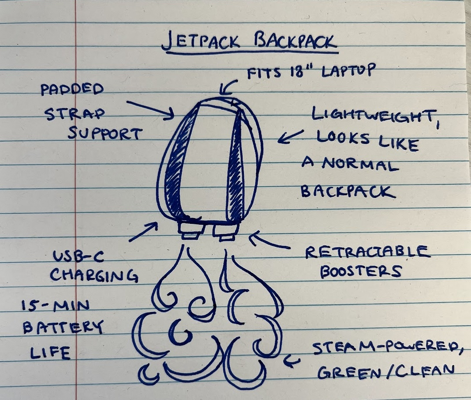

Here's a description of the image:

The image is a hand-drawn sketch on lined notebook paper, depicting a concept for a "Jetpack Backpack."  The drawing is done in blue ink. 


The central element is a simple sketch of a backpack, somewhat stylized but resembling a typical backpack in shape.  Arrows and text annotations explain its features:

* **The Backpack Itself:** It's described as lightweight and designed to look like a regular backpack, capable of fitting an 18-inch laptop.  It has padded strap support indicated by an arrow pointing to the straps.

* **The Jetpack Feature:**  Below the backpack, small square shapes represent thrusters, with stylized, swirling lines emanating from them, suggesting steam or vapor.  These are labeled "Retractable Boosters."  These boosters are described as "Steam-powered, Green/Clean," indicating an environmentally friendly propulsion system.

* **Power Source:**  An arrow points to the backpack's side, indicating a USB-C charging port.  The text n

In [141]:
import requests
import PIL.Image
from IPython.display import Image, display

# download and display sample image
img = PIL.Image.open(requests.get('https://storage.googleapis.com/generativeai-downloads/images/jetpack.jpg', stream=True).raw).copy()
display(img.resize((int(img.width / img.height * 400), 400)))

# ask the model to describe the image
response = model.generate_content(
    contents=[
        {
            "role": "user",
            "parts": [
                {
                    "text": "Read the image and describe it in detail."
                },
                img
            ]
        }
    ],
    stream=True,
    generation_config=genai.GenerationConfig(
        max_output_tokens=512,
        temperature=0.5,
    )
)
for chunk in response:
    print(chunk.text, end='', flush=True)


### Testing the API JSON mode

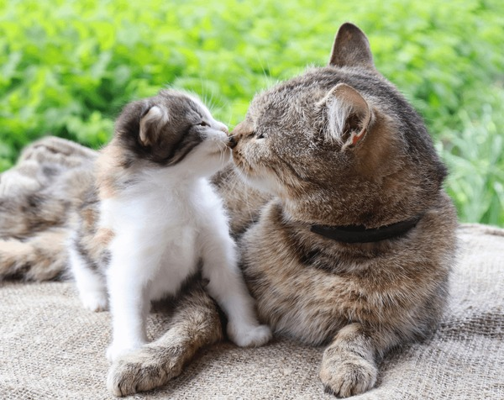

{'action_description': 'Two cats are shown in the image. One is an adult tabby '
                       'cat, and the other is a small kitten.',
 'cats': [{'color': 'tabby', 'estimated_age': 1.0, 'role': 'mother'},
          {'color': 'white with calico markings',
           'estimated_age': 0.25,
           'role': 'kitten'}],
 'count': 2}


In [57]:
import sys
import json


if sys.version_info < (3, 12):
    from typing_extensions import TypedDict
else:
    from typing import TypedDict

# download and display sample image
img = PIL.Image.open(requests.get('https://www.shutterstock.com/image-photo/cat-striped-mom-takes-care-600nw-1770843230.jpg', stream=True).raw).copy()
display(img.resize((int(img.width / img.height * 400), 400)))

# define data structure
class Cat(TypedDict):
    role: str
    estimated_age: float
    color: str

class ImageData(TypedDict):
    cats: list[Cat]
    count: int
    action_description: str

# ask the model to describe the image and return the data in JSON format following the defined schema
response = model.generate_content(
    contents=[
        {
            "role": "user",
            "parts": [
                {
                    "text": """
Look at the image and describe the cats in detail.
Return the data in JSON format.
""".strip()
                },
                img
            ]
        }
    ],
    generation_config=genai.GenerationConfig(
        response_mime_type="application/json",
        response_schema=ImageData,
        temperature=0,
    )
)

json_text = response.text
json_data = json.loads(json_text)

from pprint import pprint
pprint(json_data)